In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 14.1 MB/s eta 0:00:00


In [3]:
import cv2
import mediapipe as mp
import pandas as pd
import os
import time
import numpy as np

# Renaming images

In [ ]:
# # Specify the main directory containing the folders
# main_directory = r"C:\Users\Legion\Desktop\sign lan\ara_sign"

# # Loop through each folder in the main directory
# for folder_name in os.listdir(main_directory):
#     folder_path = os.path.join(main_directory, folder_name)

#     # Check if it's a directory
#     if os.path.isdir(folder_path):
#         # Loop through each file in the folder
#         for index, filename in enumerate(os.listdir(folder_path), start=1):
#             file_path = os.path.join(folder_path, filename)
#             file_extension = os.path.splitext(filename)[1]

#             # Check if it's an image file
#             if file_extension.lower() in ['.jpg', '.jpeg', '.png']:
#                 new_name = f"{folder_name}_{index}{file_extension}"
#                 new_path = os.path.join(folder_path, new_name)

#                 # Rename the file
#                 os.rename(file_path, new_path)

# print("Renaming completed!")



Renaming completed!


# make data augmentation

In [4]:
from google.colab.patches import cv2_imshow

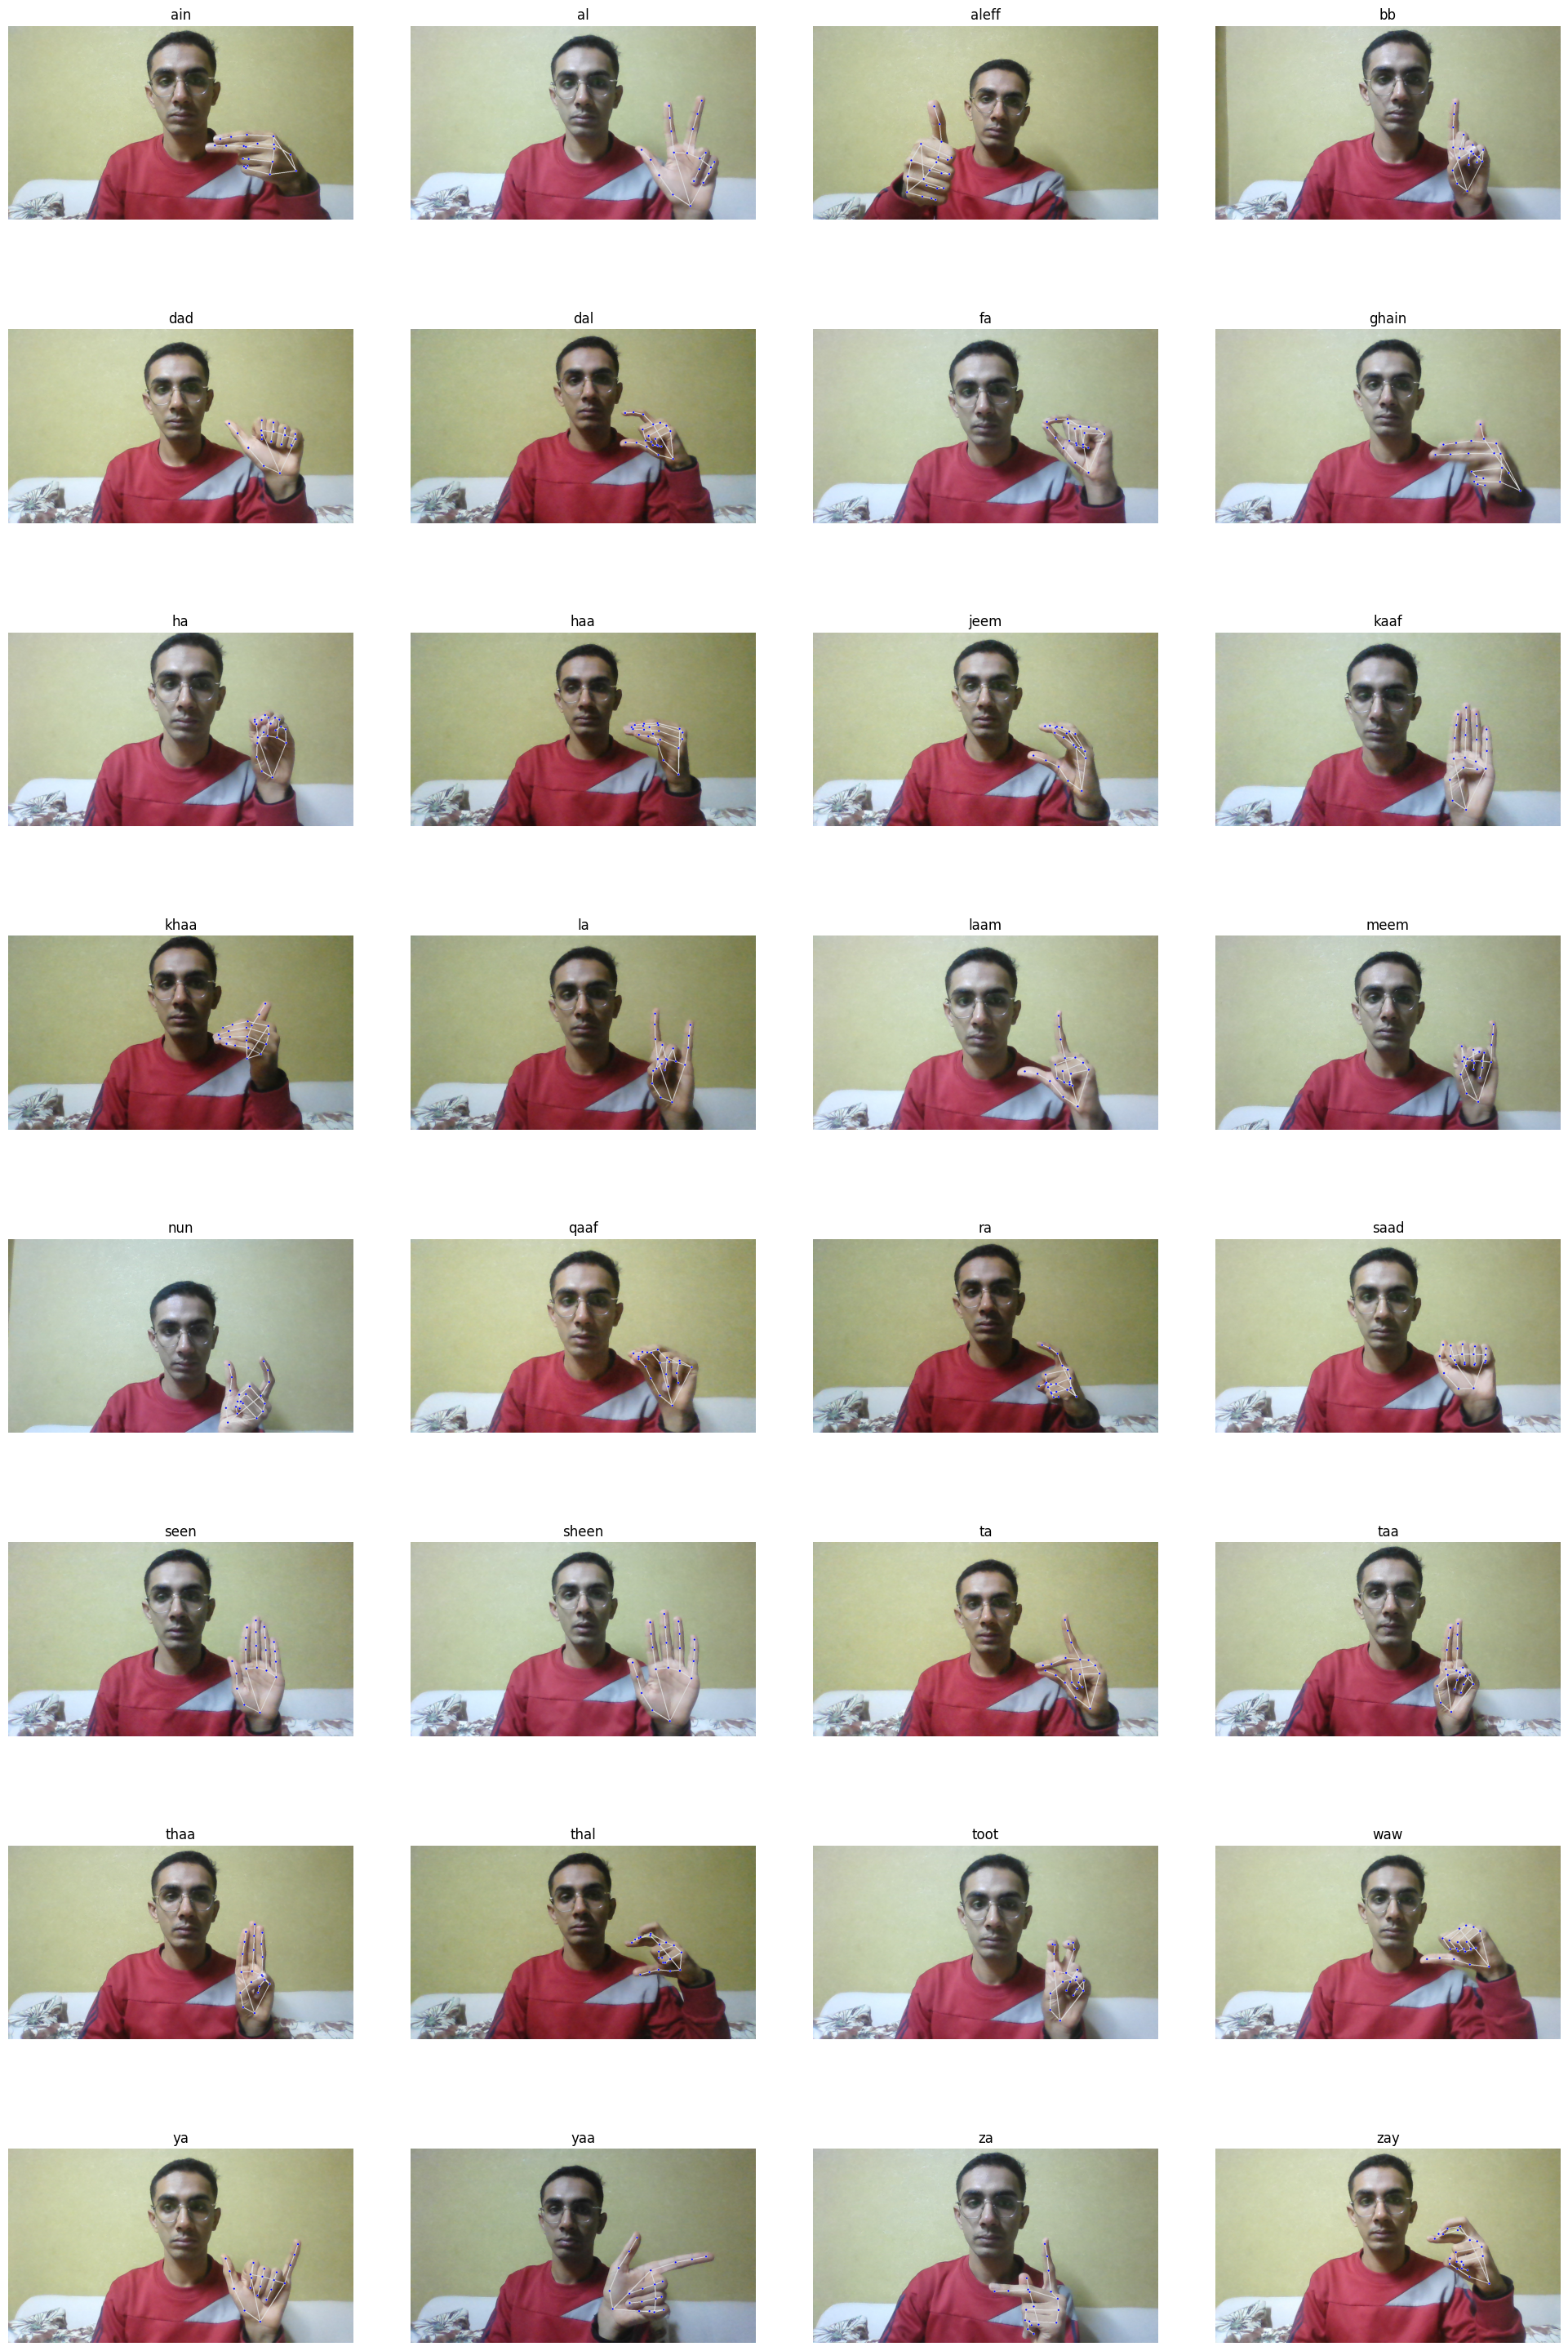

In [5]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import os

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Directory containing the Arabic sign language images
base_dir = '/content/drive/MyDrive/arabic_sign/ara_sign'

# Get all folder names (32 letters)
folders = sorted(os.listdir(base_dir))

# Prepare image paths (one image per folder)
image_paths = [os.path.join(base_dir, folder, f"{folder}_1.jpg") for folder in folders if os.path.isdir(os.path.join(base_dir, folder))]

# Set up an 8x4 plot for 32 images
fig, axs = plt.subplots(8, 4, figsize=(20, 30))
fig.tight_layout(pad=2.0)

# Process and display each image
with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    for idx, img_path in enumerate(image_paths):
        if idx >= 32:  # Limit to 32 images
            break
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read image: {img_path}")
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Process the image to find hand landmarks
        results = hands.process(image_rgb)

        # Draw landmarks if hands are detected
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(image_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Plot the image in the grid
        row, col = divmod(idx, 4)
        axs[row, col].imshow(image_rgb)
        axs[row, col].axis('off')
        axs[row, col].set_title(f"{folders[idx]}")

plt.show()


In [21]:
print(hand_landmarks.landmark[0])

x: 0.793514192
y: 0.695396185
z: -3.60648414e-07



# make the csv file for landmarks

In [23]:
import cv2
import mediapipe as mp
import os
import pandas as pd

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Directory containing the Arabic sign language images
base_dir = '/content/drive/MyDrive/arabic_sign/ara_sign'

# Get all folder names (classes)
folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])

# Create a label encoder dictionary
label_encoder = {folder: idx for idx, folder in enumerate(folders)}

# Initialize a list to store data
data = []

# Process each image and extract landmarks
with mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5) as hands:
    for folder in folders:
        folder_path = os.path.join(base_dir, folder)
        for img_name in os.listdir(folder_path):
            if img_name.endswith(('.jpg', '.png')):
                img_path = os.path.join(folder_path, img_name)
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Could not read image: {img_path}")
                    continue
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Process the image to find hand landmarks
                results = hands.process(image_rgb)

                # Extract x, y landmarks if hands are detected
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        landmarks = {}
                        for idx, lm in enumerate(hand_landmarks.landmark):
                            landmarks[f'x_{idx}'] = lm.x
                            landmarks[f'y_{idx}'] = lm.y
                        data.append({
                            'image_name': img_name,
                            **landmarks,
                            'class': folder,
                            'label': label_encoder[folder]
                        })

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('sign_language_landmarks.csv', index=False)

# Save the label encoder dictionary
import json
with open('label_encoder.json', 'w') as f:
    json.dump(label_encoder, f)

print("CSV file and label encoder saved successfully.")


CSV file and label encoder saved successfully.


# Save csv files in drive

In [27]:
# Path to the dataset directory
dataset_dir = '/content/drive/MyDrive/arabic_sign'
output_csv = os.path.join(dataset_dir, 'hand_landmarks.csv')
label_encoder_path = os.path.join(dataset_dir, 'label_encoder.csv')
df.to_csv(output_csv, index=False)
label_df = pd.DataFrame(list(label_encoder.items()), columns=['class', 'label'])
label_df.to_csv(label_encoder_path, index=False)

# Desision tree

In [34]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load the dataset
data_path = '/content/drive/MyDrive/arabic_sign/hand_landmarks.csv'
data = pd.read_csv(data_path)

# Create a label mapping
unique_classes = sorted(data['class'].unique())
class_to_int = {cls: idx for idx, cls in enumerate(unique_classes)}
int_to_class = {idx: cls for cls, idx in class_to_int.items()}

# Apply the label mapping
data['label'] = data['class'].map(class_to_int)

# Prepare the features and labels
X = data.drop(['image_name', 'class', 'label'], axis=1)
y = data['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the Random Forest model
model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(report)

# Save the model
model_path = '/content/drive/MyDrive/arabic_sign/random_forest_model.joblib'
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

# Save the label mapping to a CSV
label_map_path = '/content/drive/MyDrive/arabic_sign/label_mapping.csv'
pd.DataFrame({'class': unique_classes, 'label': [class_to_int[cls] for cls in unique_classes]}).to_csv(label_map_path, index=False)
print(f"Label mapping saved to {label_map_path}")


Accuracy: 0.8707
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.92      1.00      0.96        24
           2       0.78      0.82      0.80        22
           3       0.79      0.83      0.81        23
           4       0.82      0.61      0.70        23
           5       0.90      0.83      0.86        23
           6       0.78      0.95      0.86        22
           7       0.86      0.78      0.82        23
           8       0.88      0.95      0.91        22
           9       0.95      0.91      0.93        23
          10       1.00      0.91      0.95        23
          11       0.87      0.91      0.89        22
          12       0.90      0.78      0.84        23
          13       0.96      1.00      0.98        23
          14       0.90      0.82      0.86        22
          15       1.00      0.91      0.95        22
          16       0.96      1.00      0.98        22
          

In [33]:
print("Expected number of features:", model.n_features_in_)

Expected number of features: 42


# Evaluation

In [ ]:
import cv2
import numpy as np
import joblib
import mediapipe as mp

# Load the trained model
model = joblib.load(r'C:\Users\Legion\Desktop\sign lan\random_forest_model.joblib')

# Hardcoded label encoder dictionary
label_mapping = {
    0: "ain", 1: "al", 2: "aleff", 3: "bb", 4: "dad", 5: "dal", 6: "fa", 7: "ghain",
    8: "ha", 9: "haa", 10: "jeem", 11: "kaaf", 12: "khaa", 13: "la", 14: "laam",
    15: "meem", 16: "nun", 17: "qaaf", 18: "ra", 19: "saad", 20: "seen", 21: "sheen",
    22: "ta", 23: "taa", 24: "thaa", 25: "thal", 26: "toot", 27: "waw", 28: "ya",
    29: "yaa", 30: "za", 31: "zay"
}

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Start video capture
cap = cv2.VideoCapture(0)

with mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR image to RGB and process it
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        landmarks = []
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

                # Extract x and y coordinates for each landmark
                landmarks = [coord for lm in hand_landmarks.landmark for coord in (lm.x, lm.y)]

            # Ensure the landmarks array has exactly 42 features
            if len(landmarks) == 42:
                landmarks_array = np.array(landmarks).reshape(1, -1)

                # Predict the class
                prediction = model.predict(landmarks_array)[0]
                print(f"Raw prediction: {prediction} (type: {type(prediction)})")

                # Convert prediction to int if necessary
                if isinstance(prediction, np.generic):
                    prediction = int(prediction)

                # Get the class name from the dictionary
                predicted_class = label_mapping.get(prediction, "Unknown")

                # Display the predicted class on the frame
                frame = cv2.flip(frame, 1)
                cv2.putText(frame, predicted_class, (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 255), 4)
            else:
                cv2.putText(frame, "Incomplete landmarks", (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        cv2.imshow('Arabic Sign Language Detection', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()
